In [1]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binom, norm

from src.data import load_data
from src.paths import PREDICTION_DIR

# Data

In [2]:
game_data = load_data(2015, 2025)

prediction_data = []
for file_path in PREDICTION_DIR.glob("state_space_*.csv"):
    parts = file_path.stem.split("_")
    season = int(parts[-2])
    week = int(parts[-1])
    df = pd.read_csv(file_path)
    df["season"] = season
    df["week"] = week
    prediction_data.append(df)
prediction_data = pd.concat(prediction_data, axis=0)

data = pd.merge(
    game_data,
    prediction_data,
    on=["season", "week", "home_team", "away_team"],
    how="inner",
)

In [3]:
data.head()

,season,week,home_team,away_team,is_neutral,spread_line,result,home_win_prob,prediction_mean,prediction_std,...,away_strength_ci_90,away_strength_ci_91,away_strength_ci_92,away_strength_ci_93,away_strength_ci_94,away_strength_ci_95,away_strength_ci_96,away_strength_ci_97,away_strength_ci_98,away_strength_ci_99
0,2015,1,NE,PIT,0,7.5,7.0,0.99075,7.976669,3.643132,...,4.438900,4.603640,4.791926,5.020876,5.246523,5.546022,5.867245,6.253416,6.689302,7.914427
1,2015,1,BUF,IND,0,-1.0,13.0,0.85600,3.650672,3.679977,...,4.129898,4.286253,4.476554,4.654855,4.828382,5.061879,5.396465,5.827853,6.496930,7.470424
2,2015,1,CHI,GB,0,-5.5,-8.0,0.07600,-5.258375,3.919709,...,7.339283,7.538702,7.718634,7.921201,8.250371,8.554867,8.984940,9.415673,10.011526,10.861044
3,2015,1,HOU,KC,0,-1.0,-7.0,0.60100,0.803167,3.936032,...,5.518817,5.668274,5.838843,6.092961,6.349277,6.587310,7.090564,7.395219,8.049747,8.985701
4,2015,1,JAX,CAR,0,-3.0,-11.0,0.23775,-2.713419,3.930492,...,3.798132,3.943797,4.080990,4.271024,4.441196,4.667574,5.018851,5.377887,5.997219,6.637676


# Methodology

Each row of the data represents a historical game and contains the following features:
- Season
- Week
- Home Team
- Away Team
- Closing Spread (positive means the home team was favored)
- Game Result (home team score - away team score)
- Model Predictions (model generated percentiles of the predicted score differential distribution)

For each game we identify where the closing spread falls within the model's predicted distribution. This is done by finding the percentile index (*spread_idx*) such that:

$$
spread\_idx = P(\text{Predicted Score Differential} \leq \text{Actual Closing Spread})
$$

Intuitively:
- A *spread_idx* near **50** means the closing line closely matches the model's expectation.
- A *spread_idx* near **0** or **100** means the lines is far from what the model predicts--suggesting a potential market inefficiency.

The following figure illustrates this concept. The blue curve represents the model's predicted distribution of score differentials, and the dashed red line shows where the actual closing spread lies within that distribution.

In this example, the closing spread lies far to the right of the model’s expected distribution (*spread_idx = 84*). This indicates that the market may be overestimating the home team’s advantage, and the model would favor a bet on the away team.

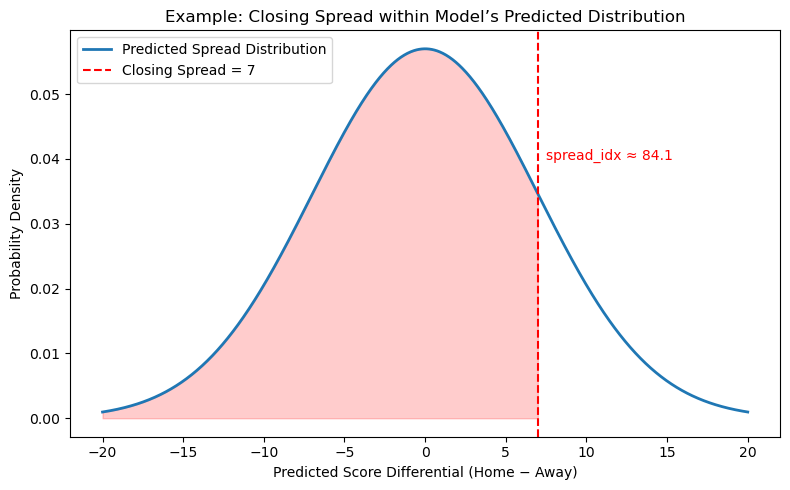

In [4]:
x = np.linspace(-20, 20, 1000)
mean, std = 0, 7
pdf = norm.pdf(x, mean, std)
closing_spread = 7

plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label="Predicted Spread Distribution", lw=2)
plt.axvline(
    closing_spread,
    color="red",
    linestyle="--",
    label=f"Closing Spread = {closing_spread}",
)
plt.fill_between(x, 0, pdf, where=(x <= closing_spread), color="red", alpha=0.2)
percentile = norm.cdf(closing_spread, mean, std) * 100
plt.text(
    closing_spread + 0.5, max(pdf) * 0.7, f"spread_idx ≈ {percentile:.1f}", color="red"
)
plt.title("Example: Closing Spread within Model’s Predicted Distribution")
plt.xlabel("Predicted Score Differential (Home − Away)")
plt.ylabel("Probability Density")
plt.legend()
plt.tight_layout()
plt.show()

To express the *spread_idx* in a simple, human-understandable way, we define:

$$
confidence = \frac{|spread\_idx - 50|}{50}
$$

Values range from **0 (uncertain)** to **1 (confident)**. For example, a *spread_idx* of 80 or 20 would yield a confidence of 0.6 (or 60% confident). This metric allows us to summarize how "sure" the model is about each prediction while maintaining intuitive interpretability.

To test whether this confidence translates into practical value, we simulate a simple betting strategy:

- Define a **minimum confidence threshold** (e.g., 0.5, 0.6, 0.7). Only games where the model's confidence exceeds this threshold are considered for betting.
- For each qualifying game:
  - Bet on the **away team** if `spread_idx > 50`
  - Bet on the **home team** if `spread_idx < 50`
- Determine wins and losses by comparing the actual game result to the closing spread in the predicted direction.

By iterating through a range of confidence thresholds, we measure:
- **Bets Placed** – Number of games meeting the confidence cutoff
- **Bets Won** – Number of correct predictions among those bets
- **Accuracy** – `Bets Won / Bets Placed`

# Results

In [5]:
def find_spread_percentile(row):
    """Find which percentile the spread falls at in the model's prediction."""
    spread = row["spread_line"]
    percentiles = row[[f"prediction_ci_{i:02d}" for i in range(1, 100)]].values
    idx = np.searchsorted(percentiles, spread, side="left")  # a[i-1] < v <= a[i]
    return idx


def betting_simulation(df, confidence_threshold):
    """Simulate a betting strategy based on model confidence."""
    bets_placed = 0
    bets_won = 0

    for row in df.itertuples():
        # Only consider games above the confidence threshold
        if row.confidence < confidence_threshold:
            continue

        # Model favors away team (ignore pushes)
        if row.spread_idx > 50:
            if row.result < row.spread_line:
                bets_placed += 1
                bets_won += 1
            elif row.result > row.spread_line:
                bets_placed += 1

        # Model favors home team (ignore pushes)
        elif row.spread_idx < 50:
            if row.result > row.spread_line:
                bets_placed += 1
                bets_won += 1
            elif row.result < row.spread_line:
                bets_placed += 1

    accuracy = bets_won / bets_placed if bets_placed > 0 else np.nan
    return bets_placed, bets_won, accuracy

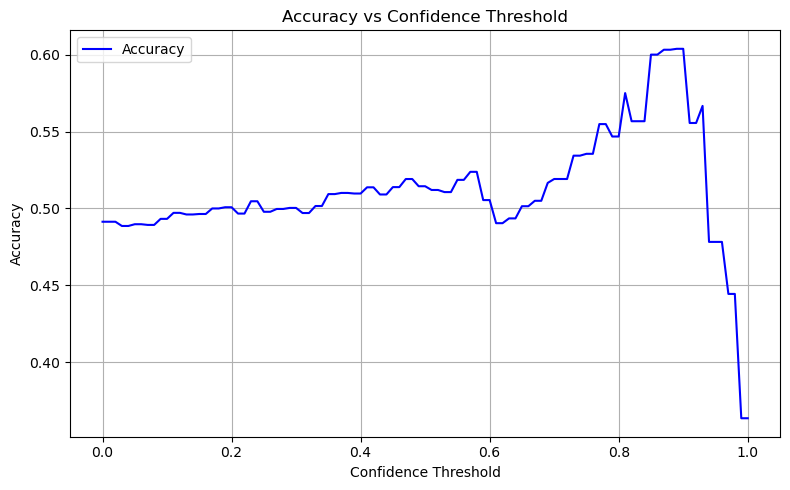

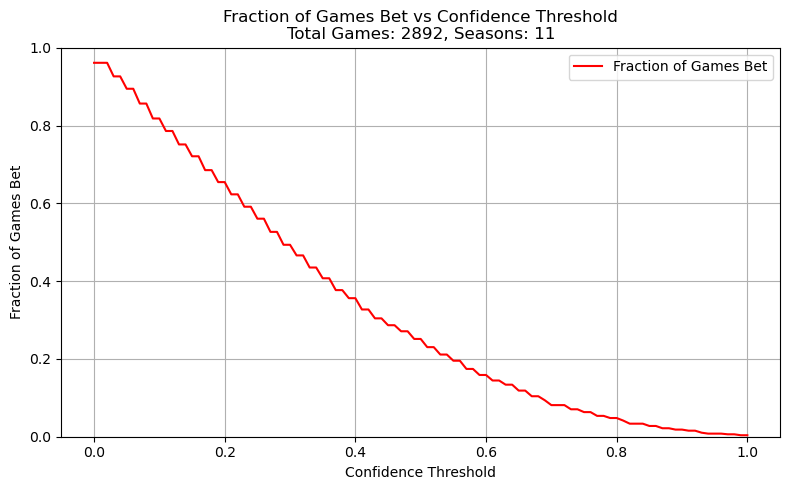

In [6]:
# Store spread_idx and confidence
data["spread_idx"] = data.apply(lambda row: find_spread_percentile(row), axis=1)
data["confidence"] = (data["spread_idx"] - 50).abs() / 50

# Define confidence thresholds
thresholds = np.linspace(0, 1, 101)

# Compute simulation results
results = []
for thresh in thresholds:
    bets_placed, bets_won, accuracy = betting_simulation(
        data, confidence_threshold=thresh
    )
    results.append([thresh, bets_placed, accuracy])
results = np.array(results)
conf_thresh = results[:, 0]
bets_placed = results[:, 1]
accuracy = results[:, 2]
total_games = len(data)
total_seasons = data["season"].nunique()

# Plot 1: Accuracy vs Confidence Threshold
plt.figure(figsize=(8, 5))
plt.plot(conf_thresh, accuracy, color="blue", label="Accuracy")
plt.title("Accuracy vs Confidence Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Fraction of Games Bet vs Confidence Threshold
plt.figure(figsize=(8, 5))
plt.plot(
    conf_thresh,
    bets_placed / total_games,
    color="red",
    label="Fraction of Games Bet",
)
plt.title(
    "Fraction of Games Bet vs Confidence Threshold"
    f"\nTotal Games: {total_games}, Seasons: {total_seasons}"
)
plt.xlabel("Confidence Threshold")
plt.ylabel("Fraction of Games Bet")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation

As seen in the previous section, the model performs well overall, achieving up to 60% accuracy against the spread at higher confidence levels when aggregated across all seasons. However, performance is not uniform across individual seasons. In this section, we examine per-season results to understand the variability in accuracy, explain why some seasons may appear less successful purely due to probabilistic factors, and explore specific cases where the model’s predictions could be improved, such as games affected by key player injuries.

To understand how the model performs in different contexts, we examine accuracy on a per-season basis. The following figure shows the model's accuracy at varying confidence thresholds for each individual season:

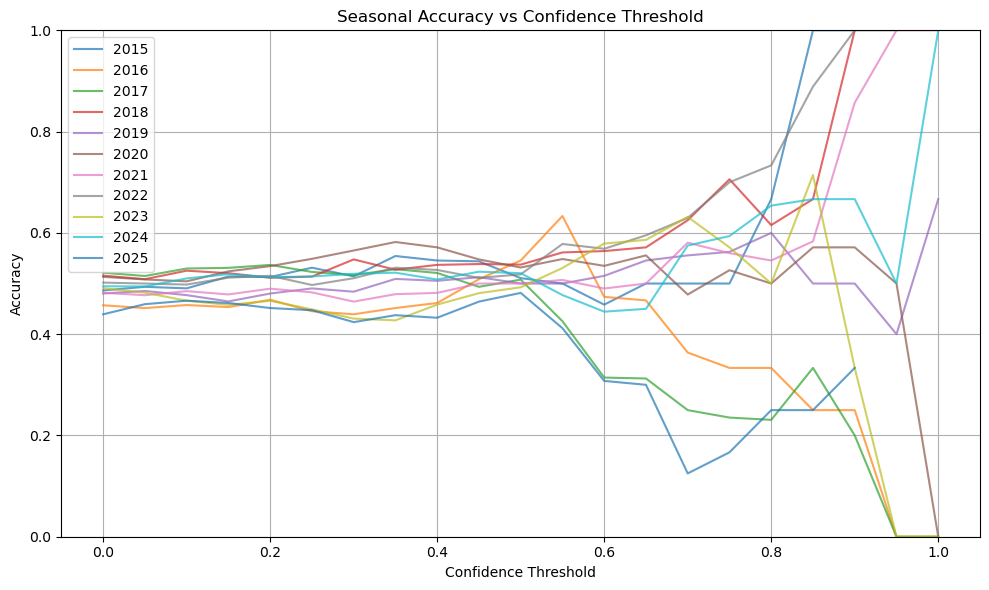

In [7]:
thresholds = np.linspace(0, 1, 21)
seasons = data["season"].unique()

plt.figure(figsize=(10, 6))
for season in seasons:
    season_data = data[data["season"] == season]
    accuracies = []
    for thresh in thresholds:
        _, _, acc = betting_simulation(season_data, confidence_threshold=thresh)
        accuracies.append(acc)
    plt.plot(thresholds, accuracies, label=f"{season}", alpha=0.7)
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Seasonal Accuracy vs Confidence Threshold")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

While the overall trend shows higher confidence levels correspond to higher accuracy, individual seasons often deviate from this pattern. This seasonal variation might be expected due to the probabilistic nature of sports outcomes. Even if the model has a true winning probability of **p=55%**, a limited number of bets in a single season can produce apparent underperformance purely by chance.

We can formalize this using the binomial distribution. Let **n** be the number of bets placed in a season (for example, around 20 bets per season at a 75% confidence level), and let **W ~ Binomial(n, p)** represent the number of wins. 

The probability of a losing season (winning fewer than half of the bets) is:

$$
P(W < 10) = \sum_{k=0}^{9} \binom{20}{k} 0.55^k \cdot 0.45^{20-k}
$$

In [8]:
prob_losing = binom.cdf(9, 20, 0.55)
print(f"Probability of losing season: {prob_losing:.2%}")

Probability of losing season: 24.93%


To further illustrate the model's limitations, we examine a set of high-confidence predictions from the 2025 season:

In [9]:
data[(data["season"] == 2025) & (data["confidence"] > 0.9)][
    [
        "season",
        "week",
        "home_team",
        "away_team",
        "prediction_mean",
        "spread_line",
        "result",
    ]
]

,season,week,home_team,away_team,prediction_mean,spread_line,result
2809,2025,5,BAL,HOU,5.729821,-2.5,-34.0
2823,2025,6,BAL,LA,1.177969,-7.0,-14.0
2882,2025,10,HOU,JAX,7.491305,-1.5,7.0


In these high-confidence games from the 2025 season, key quarterbacks were unavailable: Lamar Jackson was injured in Week 4, and C.J. Stroud was out in Week 10. The model does not currently have access to this information, which helps explain why these predictions deviated from the actual results.

It is difficult to determine whether Vegas accurately adjusts spreads for injuries—explaining why our model performs well in aggregate—or whether our model underperforms in these situations simply because it lacks injury data. The only way to address this is to incorporate injury and lineup information, which we plan to do in future iterations of the model.